# 0. Setup

tf version: 1.15.0
keras version: 2.2.5
pandas version: 0.25.3


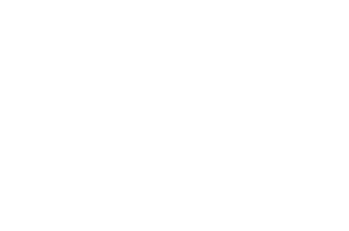

In [245]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd

print(f"tf version: {tf.__version__}")
print(f"keras version: {keras.__version__}")
print(f"pandas version: {pd.__version__}")
%matplotlib inline
plt.style.use('ggplot')
plt.axis('off')
IMAGE_WIDTH = 96

np.random.seed(0)

# 1. Download data from Kaggle

In [246]:
#!pip install kaggle   #install kaggle library
#!mkdir ~/.kaggle         #make a directory named .kaggle 
#files.upload() # upload kaggle.json (it contains your API token) file 
#!cp kaggle.json ~/.kaggle/
#!ls ~/.kaggle/*
#!chmod 600 ~/.kaggle/kaggle.json  
#!kaggle datasets list
!kaggle competitions download -c facial-keypoints-detection

training.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
IdLookupTable.csv: Skipping, found more recently modified local copy (use --force to force download)
SampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [247]:
!ls

 baseline-LeNet5.h5  'kaggle (2).json'	 SampleSubmission.csv
 IdLookupTable.csv    kaggle.json	 test.zip
'kaggle (1).json'     sample_data	 training.zip


# 2. Data Preprocessing & Exploratory Data Analysis

In [0]:
# load data
train_data = pd.read_csv("training.zip")
test_data = pd.read_csv("test.zip")
meta_data = pd.read_csv("IdLookupTable.csv")

In [249]:
# let's look at train data set
train_data.info()
train_data.head(5).T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


There are 31 columns in this dataset. Each column except the last one represents a facial feature point as a float in given diemsion. Last column contains image dataset as a string. Let's check if there is any missing dataset

In [265]:
print(train_data.isnull().any().value_counts())
train_data.columns[train_data.isnull().any()]

True     28
False     3
dtype: int64


Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'mouth_left_corner_x',
       'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y',
       'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'],
      dtype='object')

Out of 31 columns, there are 28 columns which have missing values.


In [267]:
# find out number of number of rows with missing values
print(f"Total number of rows: {train_data.shape[0]}")
print(f"Total number of rows with NaN : {train_data.shape[0] - train_data.dropna().shape[0]}")

Total number of rows: 7049
Total number of rows with NaN : 4909


There are `4909` rows with missing values. It looks like there are two groups of features in the dataset. First group of features have the number of rows between 7016 ~ 7049. These are `left_eye_center_x `, `left_eye_center_y`, `right_eye_center_x`, `right_eye_center_y`, `mouth_center_bottom_lip_x`, and `mouth_center_bottom_lip_y`. Second group of features have the number of rows between 2225 ~ 2275. How do we handle this? Should we create two different models to handle each group? Or move the rows with missing values? Or fill in missing values other values. 


In [0]:
# for now, use values from the previous rows
train_data.fillna(method="ffill", inplace = True)

Let's convert image object to numpy array and store them in *X_train*

In [253]:
def convert_df_to_np_2d(df,image_size):
  dataset = np.vstack(train_data["Image"].apply(lambda row:np.fromstring(row,sep=' ')).to_numpy())
  dataset = dataset.astype(np.float32)
  dataset = dataset.reshape(-1,image_size,image_size,1)
  return dataset

X_train = convert_df_to_np_2d(train_data["Image"], IMAGE_WIDTH)
print(X_train.shape)

(7049, 96, 96, 1)


Let's store predictor variables in *y_train*

In [254]:
y_train = np.delete(train_data.to_numpy(),-1,axis=1) #removing the last column(Image)
y_train.shape

(7049, 30)

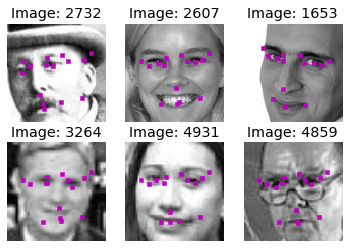

In [255]:
def show_image(img: np.ndarray):
  plt.axis('off')
  plt.imshow(key_points[0:30:2],cmap="gray")

def show_image_with_key_points(img: np.ndarray, key_points: np.ndarray, image_number, axis):
  axis.axis('off')
  axis.imshow(img[:,:,0],cmap="gray")
  axis.scatter(key_points[0:30:2],key_points[1:30:2], s=10,marker=',',c='m')
  axis.set_title(f"Image: {image_number}")

def show_multiple_samples(image_set, feature_set, number_of_images: int, images_per_row = 3):
  fig, axis = plt.subplots(number_of_images//images_per_row, images_per_row)
  for i in range(number_of_images):
    image_number = np.random.randint(0, image_set.shape[0])
    show_image_with_key_points(image_set[image_number], feature_set[image_number], 
                              image_number , axis[i//images_per_row,
                                                  i%images_per_row])
show_multiple_samples(X_train,y_train, 6)

Let's preprocess the test data set and store it in *X_test*


In [256]:
test_data.fillna(method="ffill", inplace = True)
test_data.head(5).T
X_test = convert_df_to_np_2d(test_data["Image"], IMAGE_WIDTH)
print(X_test.shape)

(7049, 96, 96, 1)


# 3. BaseLine Model using Naive LeNet-5

In [257]:
def create_naive_LeNet5_model(input_shape):
  print(f"Initializing LeNet5 model with input-size: {input_shape}")
  model = keras.Sequential()
  model.add(keras.layers.InputLayer(input_shape))
  model.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=120, activation='relu'))
  model.add(keras.layers.Dense(units=84, activation='relu'))
  model.add(keras.layers.Dense(units=30))
  return model

LeNet5_model = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

Initializing LeNet5 model with input-size: (96, 96, 1)


In [258]:
#train it!
result = LeNet5_model.fit(X_train,y_train,epochs = 50,batch_size = 256,validation_split = 0.2)

Train on 5639 samples, validate on 1410 samples
Epoch 1/50
5639/5639 [==============================] - 2s 275us/step - loss: 557.4919 - mean_absolute_error: 17.1245 - val_loss: 136.3592 - val_mean_absolute_error: 8.7826
Epoch 2/50
5639/5639 [==============================] - 1s 161us/step - loss: 129.4409 - mean_absolute_error: 8.6417 - val_loss: 119.2184 - val_mean_absolute_error: 8.0244
Epoch 3/50
5639/5639 [==============================] - 1s 161us/step - loss: 103.2811 - mean_absolute_error: 7.6497 - val_loss: 93.9755 - val_mean_absolute_error: 7.1659
Epoch 4/50
5639/5639 [==============================] - 1s 163us/step - loss: 87.0397 - mean_absolute_error: 6.9914 - val_loss: 93.5784 - val_mean_absolute_error: 7.1028
Epoch 5/50
5639/5639 [==============================] - 1s 161us/step - loss: 79.5897 - mean_absolute_error: 6.6645 - val_loss: 98.1199 - val_mean_absolute_error: 7.4227
Epoch 6/50
5639/5639 [==============================] - 1s 160us/step - loss: 74.9158 - mean_abs

In [0]:
# save it
LeNet5_model.save("baseline-LeNet5.h5")

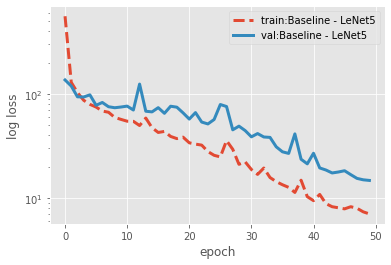

In [260]:
# let's plot validation and train loss
def plot_history(history, name, RMSE_TF=False):
  loss = history['loss']
  val_loss = history['val_loss']
  plt.plot(figsize=(15,10))
  plt.plot(loss,"--",linewidth=3,label="train:"+name)
  plt.plot(val_loss,linewidth=3,label="val:"+name)
  plt.yscale("log")
  plt.xlabel("epoch")
  plt.ylabel("log loss")
  plt.legend()
  plt.grid(True)
plot_history(result.history, "Baseline - LeNet5")

Evaluate the model performance against test data

In [0]:
y_test = LeNet5_model.predict(X_test)

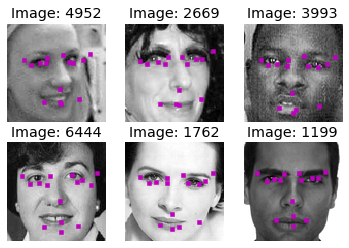

In [262]:
show_multiple_samples(X_test, y_test, 6)